In [1]:
import glob
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.concat(pd.Series(glob.glob('/home/daniel/wizepair2/notebooks/elo/elo_input-*.json.gz')).parallel_apply(pd.read_json, lines=True).tolist())

In [4]:
df.publication_date_greatest = pd.to_datetime(df.publication_date_greatest)
df.sort_values('publication_date_greatest', inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df['label'] = df.standard_change=='increase'

In [6]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,publication_date_greatest,fragment1,fragment2,radius,pref_name,chessleague_uuid,chessleague_partition,label
0,b30e992c8539bf855032e7a111f76808,688756,Potency,decrease,1970-01-01,d32e61ed89b4e69e56c321ca2b171450,bcb676e9ba13f59b37f891ae87d2ec9b,1,MAP kinase ERK2,9b01963ec35d75c8da44c4e247e67911,22,False
1,4cbdbc310e5d3a312229150f68bb3f60,1915787,Inhibition,no-change,1970-01-01,3836bbb8c25d56650267be2226d0eab3,1c23458c2aa6464b8a5fd0861163ea91,1,"Sulfide:quinone oxidoreductase, mitochondrial",8ae46a9f19a9c010e5c8dcfe88ffd670,24,False
2,1e84ed33a02e174bc64b91fd21d0f62c,1915787,Inhibition,decrease,1970-01-01,78f78afb1bb3d24b6a6279fcd75c2557,e1763067da4705d7f475739160178b12,1,"Sulfide:quinone oxidoreductase, mitochondrial",8ae46a9f19a9c010e5c8dcfe88ffd670,24,False


In [7]:
df.publication_date_greatest.quantile([0, 0.05, 0.5, 0.95, 1])

0.00   1970-01-01
0.05   1989-04-12
0.50   2009-01-08
0.95   2018-10-17
1.00   2020-11-28
Name: publication_date_greatest, dtype: datetime64[ns]

In [8]:
len(df.index)

20120367

In [9]:
def elo(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    if df.empty: return None
    
    # fit model
    model = EloEstimator(
        key1_field="fragment1",
        key2_field="fragment2",
        timestamp_field="publication_date_greatest",
        initial_time=pd.to_datetime('1970-01-01'),
        default_k=20
    ).fit(df, df.label)
    if return_ratings: return model.rating_model.to_frame()

    # calculate proba
    df['proba'] = model.transform(df, output_type='prob', strict_past_data=True)
    return df[['assay_id', 'wizepair2_uuid', 'chessleague_uuid', 'proba', 'label']]
    

In [10]:
df_elo = df.groupby(['chessleague_uuid']).parallel_apply(elo)

In [11]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.000002
0.1    0.472074
0.5    0.500000
0.9    0.527926
1.0    0.999998
Name: proba, dtype: float64

In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.5726053672454434

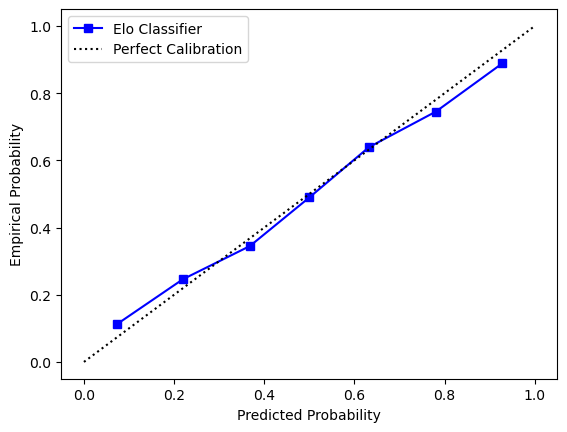

In [13]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=7
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [14]:
df_elo.sort_values('proba', ascending=False)

assay_id  \
chessleague_uuid                                      
6cd65b5fa27be3b2b0b8643f4b4adcd1 17217385   1552240   
                                 18291833   1685271   
                                 17960062   1652370   
                                 17509530   1563412   
                                 17133957   1925022   
...                                             ...   
                                 17132993   1925022   
                                 17510176   1563412   
                                 17959942   1652370   
                                 18291172   1685271   
                                 17219172   1552240   

                                                             wizepair2_uuid  \
chessleague_uuid                                                              
6cd65b5fa27be3b2b0b8643f4b4adcd1 17217385  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 18291833  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 17960062  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 17509530  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 17133957  660a5f32f3b87ff9eaac76d6ff98cf0b   
...                                                                     ...   
                                 17132993  fd0fe6b16e81218c3f233578a6056448   
                                 17510176  fd0fe6b16e81218c3f233578a6056448   
                                 17959942  fd0fe6b16e81218c3f233578a6056448   
                                 18291172  fd0fe6b16e81218c3f233578a6056448   
                                 17219172  fd0fe6b16e81218c3f233578a6056448   

                                                           chessleague_uuid  \
chessleague_uuid                                                              
6cd65b5fa27be3b2b0b8643f4b4adcd1 17217385  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18291833  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17960062  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17509530  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17133957  6cd65b5fa27be3b2b0b8643f4b4adcd1   
...                                                                     ...   
                                 17132993  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17510176  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17959942  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18291172  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 17219172  6cd65b5fa27be3b2b0b8643f4b4adcd1   

                                              proba  label  
chessleague_uuid                                            
6cd65b5fa27be3b2b0b8643f4b4adcd1 17217385  0.999998   True  
                                 18291833  0.999998   True  
                                 17960062  0.999998   True  
                                 17509530  0.999998   True  
                                 17133957  0.999998   True  
...                                             ...    ...  
                                 17132993  0.000002  False  
                                 17510176  0.000002  False  
                                 17959942  0.000002  False  
                                 18291172  0.000002  False  
                                 17219172  0.000002  False  

[20120367 rows x 5 columns]

In [15]:
df_ratings = df.groupby(['chessleague_uuid']).parallel_apply(elo, return_ratings=True)

In [16]:
df_ratings.sort_values('rating', ascending=False)

key  \
chessleague_uuid                                                           
936b2ab0848ce64836a1671bab454d8a 26251  7d10e7b4bb13ce25d0cb6302f324cb69   
                                 26250  7d10e7b4bb13ce25d0cb6302f324cb69   
                                 26249  7d10e7b4bb13ce25d0cb6302f324cb69   
                                 26248  7d10e7b4bb13ce25d0cb6302f324cb69   
                                 26247  7d10e7b4bb13ce25d0cb6302f324cb69   
...                                                                  ...   
6cd65b5fa27be3b2b0b8643f4b4adcd1 4146   ddb06c57f407ae293015c2cccf877127   
                                 4147   ddb06c57f407ae293015c2cccf877127   
                                 4148   ddb06c57f407ae293015c2cccf877127   
                                 4149   ddb06c57f407ae293015c2cccf877127   
                                 4150   ddb06c57f407ae293015c2cccf877127   

                                             rating valid_from   valid_to  
chessleague_uuid                                                           
936b2ab0848ce64836a1671bab454d8a 26251  2666.505280 2016-03-11 2016-03-11  
                                 26250  2666.480502 2016-02-06 2016-03-11  
                                 26249  2664.979245 2016-02-06 2016-02-06  
                                 26248  2664.977952 2016-02-06 2016-02-06  
                                 26247  2658.747969 2016-02-06 2016-02-06  
...                                             ...        ...        ...  
6cd65b5fa27be3b2b0b8643f4b4adcd1 4146    217.940557 2017-07-03 2017-07-03  
                                 4147    217.940457 2017-07-03 2017-07-03  
                                 4148    217.940424 2017-07-03 2017-07-03  
                                 4149    217.940325 2017-07-03 2017-07-03  
                                 4150    217.940292 2017-07-03        NaT  

[45018069 rows x 4 columns]

In [17]:
df_ratings[df_ratings.valid_to.isna()].to_csv('/home/daniel/wizepair2/elo_ratings.csv.gz', compression='gzip')